In [165]:
from pathlib import Path

from dask import dataframe as dd
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pearl.post_processing.bmi import calc_risk_by_group, clean_control, group_title_dict


In [166]:
baseline = Path("/workspaces/pearlModel/out/200_rep/S0_SA_200/combined")
variable = Path("/workspaces/pearlModel/out/200_rep/S3_SA_200/combined")

In [167]:
param_df_baseline = pd.read_parquet(baseline / "parameters.parquet").reset_index(drop=True)
param_df_variable = pd.read_parquet(variable / "parameters.parquet").reset_index(drop=True)

In [168]:
param_df_baseline.columns

Index(['replication', 'group', 'new_dx', 'final_year', 'mortality_model',
       'mortality_threshold_flag', 'idu_threshold', 'seed',
       'bmi_intervention_scenario', 'bmi_intervention_start_year',
       'bmi_intervention_end_year', 'bmi_intervention_coverage',
       'bmi_intervention_effectiveness', 'prev_users_dict_hcv',
       'prev_users_dict_smoking', 'prev_users_dict_anx', 'prev_users_dict_dpr',
       'prev_users_dict_ckd', 'prev_users_dict_lipid', 'prev_users_dict_dm',
       'prev_users_dict_ht', 'prev_users_dict_malig', 'prev_users_dict_esld',
       'prev_users_dict_mi', 'prev_inits_dict_hcv', 'prev_inits_dict_smoking',
       'prev_inits_dict_anx', 'prev_inits_dict_dpr', 'prev_inits_dict_ckd',
       'prev_inits_dict_lipid', 'prev_inits_dict_dm', 'prev_inits_dict_ht',
       'prev_inits_dict_malig', 'prev_inits_dict_esld', 'prev_inits_dict_mi',
       'sa_incidence_shift_dm', 'pre_art_bmi', 'post_art_bmi',
       'art_initiators'],
      dtype='object')

In [169]:
bmi_int_dm_prev_variable = dd.read_parquet(variable / "dm_final_output.parquet")
bmi_int_dm_prev_baseline = dd.read_parquet(baseline / "dm_final_output.parquet")

# clean to control specifications
control_bmi_int_dm_prev_variable = clean_control(bmi_int_dm_prev_variable, only_eligible=True)
control_bmi_int_dm_prev_baseline = clean_control(bmi_int_dm_prev_baseline, only_eligible=True)

# filter for only people eligible for intervention
bmi_int_eligible_risk_variable = calc_risk_by_group(control_bmi_int_dm_prev_variable, 7).compute()
bmi_int_eligible_risk_baseline = calc_risk_by_group(control_bmi_int_dm_prev_baseline, 7).compute()

In [170]:
num_samples = 2000
baseline_risk = bmi_int_eligible_risk_baseline.groupby('group').sample(num_samples, replace=True).reset_index()
variable_risk = bmi_int_eligible_risk_variable.groupby('group').sample(num_samples, replace=True).reset_index()

In [171]:
risk_df = pd.DataFrame(variable_risk['risk'] - baseline_risk['risk'])
risk_df['group'] = baseline_risk['group']

In [172]:
baseline_risk

index             group  replication  dm_num  person-time-contributed  \
0        112  het_black_female          112    3637                   127155   
1         47  het_black_female           47    2508                    99757   
2         11  het_black_female           11     142                   110754   
3         58  het_black_female           58    3330                   102137   
4         68  het_black_female           68    4767                   106183   
...      ...               ...          ...     ...                      ...   
29995   2954    msm_white_male          167       4                   305543   
29996   2917    msm_white_male          130     134                   294602   
29997   2816    msm_white_male           26    5263                   311122   
29998   2850    msm_white_male           60      19                   293167   
29999   2795    msm_white_male            5       2                   305291   

         num       risk  
0      18165  28.602886  
1      14251  25.141093  
2      15822   1.282121  
3      14591  32.603268  
4      15169  44.894192  
...      ...        ...  
29995  43649   0.013091  
29996  42086   0.454851  
29997  44446  16.916194  
29998  41881   0.064809  
29999  43613   0.006551  

[30000 rows x 7 columns]

In [173]:
baseline_risk_median = baseline_risk.groupby('group')['risk'].median().reset_index()
variable_risk_median = variable_risk.groupby('group')['risk'].median().reset_index()
baseline_risk_difference_df = risk_df.groupby('group').median().reset_index()

In [174]:
baseline_risk_median

group       risk
0   het_black_female  14.476859
1     het_black_male  16.621433
2    het_hisp_female  19.358199
3      het_hisp_male  13.849418
4   het_white_female  18.232118
5     het_white_male  19.954245
6   idu_black_female  21.255105
7     idu_black_male  17.876340
8    idu_hisp_female  24.824855
9      idu_hisp_male  11.929321
10  idu_white_female  27.354105
11    idu_white_male  10.360138
12    msm_black_male   7.309488
13     msm_hisp_male   2.131463
14    msm_white_male   9.066115

In [175]:
variable_risk_median

group       risk
0   het_black_female  11.473597
1     het_black_male  14.453976
2    het_hisp_female  20.207158
3      het_hisp_male   7.963100
4   het_white_female  18.628776
5     het_white_male  15.010116
6   idu_black_female  20.909033
7     idu_black_male  13.578942
8    idu_hisp_female  19.420332
9      idu_hisp_male  11.619959
10  idu_white_female  21.269547
11    idu_white_male   5.495397
12    msm_black_male   6.163126
13     msm_hisp_male   4.852568
14    msm_white_male  10.289001

In [176]:
baseline_risk_difference_df

group      risk
0   het_black_female -2.098916
1     het_black_male -0.935132
2    het_hisp_female -0.566484
3      het_hisp_male -1.686850
4   het_white_female -0.608155
5     het_white_male -1.363077
6   idu_black_female -1.998965
7     idu_black_male -1.694086
8    idu_hisp_female -3.095838
9      idu_hisp_male -0.166090
10  idu_white_female -3.831517
11    idu_white_male -0.108760
12    msm_black_male -0.250421
13     msm_hisp_male -0.003561
14    msm_white_male -0.014428

In [177]:
def calc_tornado_vals(baseline_risk_df, variable_risk_df, param_df_baseline, param_df_variable, col_name, num_samples=1000, lesser=0.1, greater=0.9):
    
    sub_param_baseline = param_df_baseline[['replication', 'group', col_name]]
    sub_param_variable = param_df_variable[['replication', 'group', col_name]]
    
    baseline_merged = sub_param_baseline.merge(baseline_risk_df, on=['replication', 'group'], how='left').fillna(0)
    variable_merged = sub_param_variable.merge(variable_risk_df, on=['replication', 'group'], how='left').fillna(0)
    
    quantile_val_baseline = baseline_merged.groupby('group')[col_name].quantile([lesser, greater]).unstack().reset_index()
    quantile_val_variable = variable_merged.groupby('group')[col_name].quantile([lesser, greater]).unstack().reset_index()
    
    difference_tornado_df = []
    baseline_tornado_df = []
    variable_tornado_df = []
    for group in quantile_val_baseline['group'].unique():
        group_df_baseline = baseline_merged[baseline_merged['group'] == group]
        group_df_variable = variable_merged[variable_merged['group'] == group]

        lesser_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][lesser].values[0]
        greater_val_baseline = quantile_val_baseline[quantile_val_baseline['group'] == group][greater].values[0]
        lesser_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][lesser].values[0]
        greater_val_variable = quantile_val_variable[quantile_val_variable['group'] == group][greater].values[0]
        
        lesser_group_df_baseline = group_df_baseline[group_df_baseline[col_name] <= lesser_val_baseline].sample(num_samples, replace=True).reset_index()
        greater_group_df_baseline = group_df_baseline[group_df_baseline[col_name] >= greater_val_baseline].sample(num_samples, replace=True).reset_index()
        lesser_group_df_variable = group_df_variable[group_df_variable[col_name] <= lesser_val_variable].sample(num_samples, replace=True).reset_index()
        greater_group_df_variable = group_df_variable[group_df_variable[col_name] >= greater_val_variable].sample(num_samples, replace=True).reset_index()
        
        
        baseline_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_baseline['risk']).median(),
            greater: (greater_group_df_baseline['risk']).median()
        }
        baseline_tornado_df.append(baseline_group_tornado_df)
        variable_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_variable['risk']).median(),
            greater: (greater_group_df_variable['risk']).median()
        }
        variable_tornado_df.append(variable_group_tornado_df)
        difference_group_tornado_df = {
            'group': group,
            'variable': col_name,
            lesser: (lesser_group_df_variable['risk'] - lesser_group_df_baseline['risk']).median(),
            greater: (greater_group_df_variable['risk'] - greater_group_df_baseline['risk']).median()
        }
        difference_tornado_df.append(difference_group_tornado_df)
    
    baseline_tornado_df = pd.DataFrame(baseline_tornado_df)
    variable_tornado_df = pd.DataFrame(variable_tornado_df)
    difference_tornado_df = pd.DataFrame(difference_tornado_df)
    return baseline_tornado_df, variable_tornado_df, difference_tornado_df

In [178]:
target_columns = ['prev_users_dict_dm', 'prev_inits_dict_dm', 'sa_incidence_shift_dm', 'pre_art_bmi', 'post_art_bmi', "art_initiators"]

In [179]:
variable_name_map = {
    'prev_users_dict_dm' : 'DM Prevalence at 2009',
    'prev_inits_dict_dm' : 'DM Prevalence 2009-end',
    'sa_incidence_shift_dm' : 'DM Incidence',
    'pre_art_bmi' : 'Pre ART BMI',
    'post_art_bmi' : 'Post ART BMI',
    'art_initiators' : '# ART Initiators'
}

In [180]:
baseline_tornado_vals = []
variable_tornado_vals = []
difference_tornado_vals = []
for col in target_columns:
    baseline_vals, variable_vals, difference_vals = calc_tornado_vals(bmi_int_eligible_risk_baseline,
                                                                      bmi_int_eligible_risk_variable,
                                                                      param_df_baseline,
                                                                      param_df_variable,
                                                                      col,
                                                                      lesser=0.05,
                                                                      greater=0.95)
    baseline_tornado_vals.append(baseline_vals)
    variable_tornado_vals.append(variable_vals)
    difference_tornado_vals.append(difference_vals)
baseline_tornado_vals = pd.concat(baseline_tornado_vals).reset_index(drop=True)    
variable_tornado_vals = pd.concat(variable_tornado_vals).reset_index(drop=True)
difference_tornado_vals = pd.concat(difference_tornado_vals).reset_index(drop=True)

# rename variable to semantic labels
baseline_tornado_vals['variable'] = baseline_tornado_vals['variable'].map(variable_name_map)
variable_tornado_vals['variable'] = variable_tornado_vals['variable'].map(variable_name_map)
difference_tornado_vals['variable'] = difference_tornado_vals['variable'].map(variable_name_map)

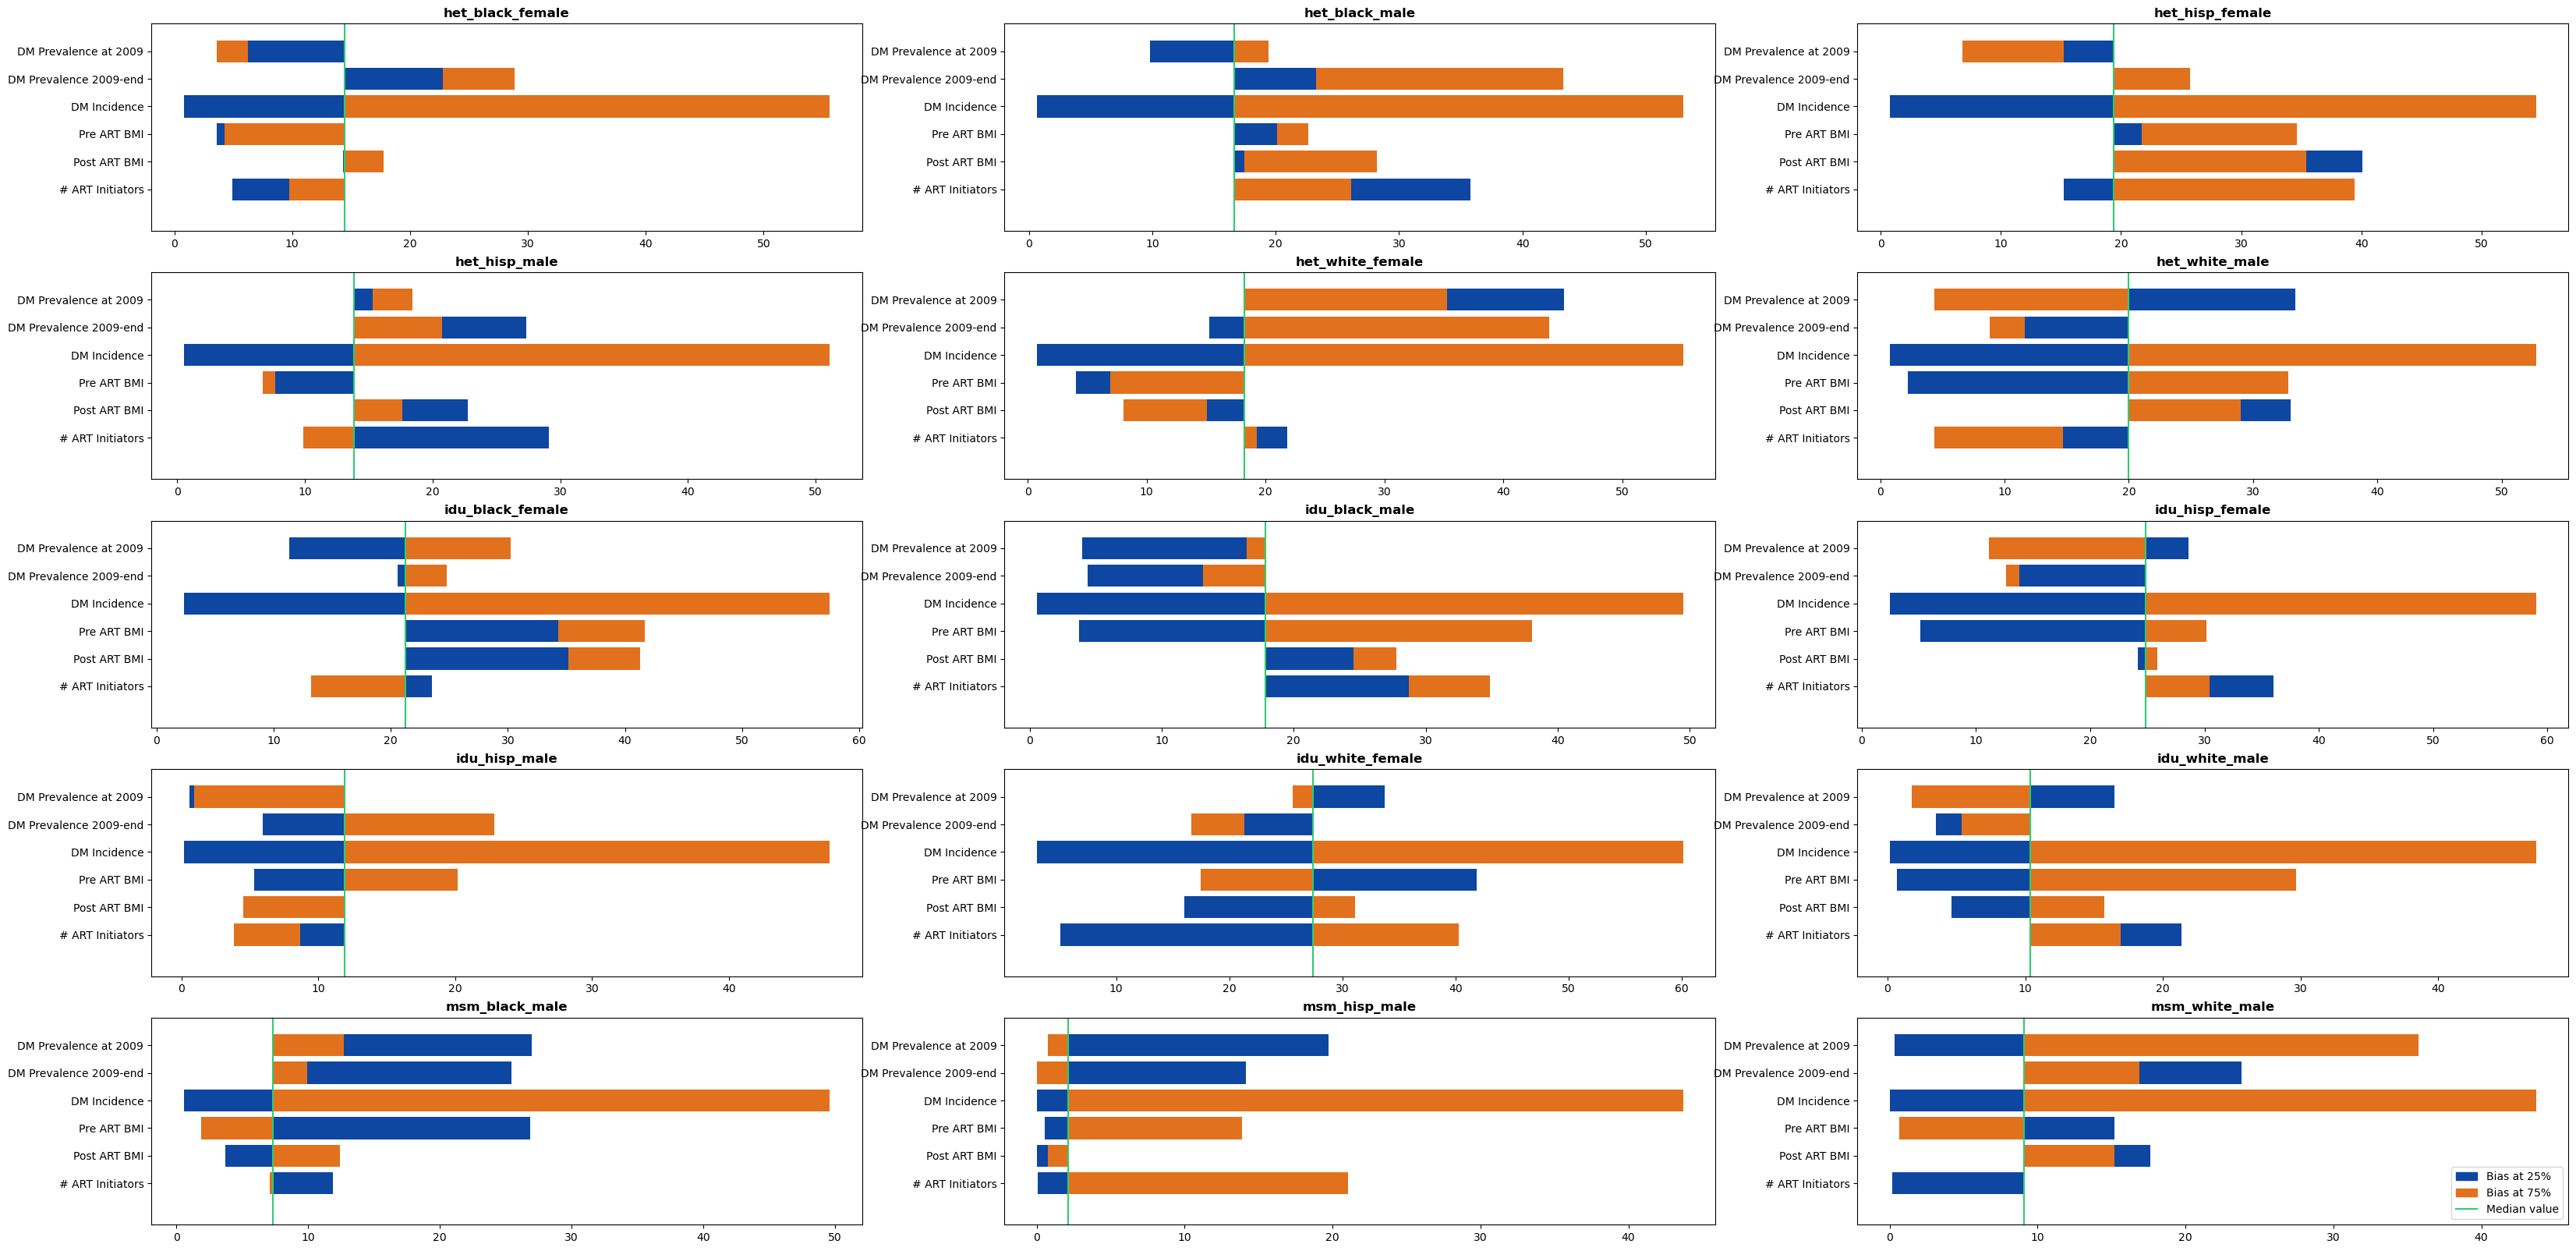

In [181]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(baseline_tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = baseline_tornado_vals[baseline_tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = baseline_risk_median[baseline_risk_median['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, value_25, value_75):
        if abs(base - value) < abs(base - value2):
            ax.broken_barh([(base, value2 - base)], (y - height/2, height),facecolors=[color_95,color_95])
            ax.broken_barh([(base, value - base)], (y - height/2,height), facecolors=[color_5,color_5])
        else:
            ax.broken_barh([(base, value - base)], (y - height/2,height), facecolors=[color_5,color_5])
            ax.broken_barh([(base, value2 - base)], (y - height/2, height),facecolors=[color_95,color_95])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_title(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')


In [182]:
het_black_baseline = baseline_tornado_vals[baseline_tornado_vals['group']== 'het_black_female']

In [183]:
het_black_baseline

group                variable       0.05       0.95
0   het_black_female   DM Prevalence at 2009   6.256824   3.629219
15  het_black_female  DM Prevalence 2009-end  22.766390  28.863741
30  het_black_female            DM Incidence   0.792275  55.617549
45  het_black_female             Pre ART BMI   3.629219   4.259121
60  het_black_female            Post ART BMI  14.284255  17.742821
75  het_black_female        # ART Initiators   4.893950   9.749108

In [184]:
baseline_risk_median

group       risk
0   het_black_female  14.476859
1     het_black_male  16.621433
2    het_hisp_female  19.358199
3      het_hisp_male  13.849418
4   het_white_female  18.232118
5     het_white_male  19.954245
6   idu_black_female  21.255105
7     idu_black_male  17.876340
8    idu_hisp_female  24.824855
9      idu_hisp_male  11.929321
10  idu_white_female  27.354105
11    idu_white_male  10.360138
12    msm_black_male   7.309488
13     msm_hisp_male   2.131463
14    msm_white_male   9.066115

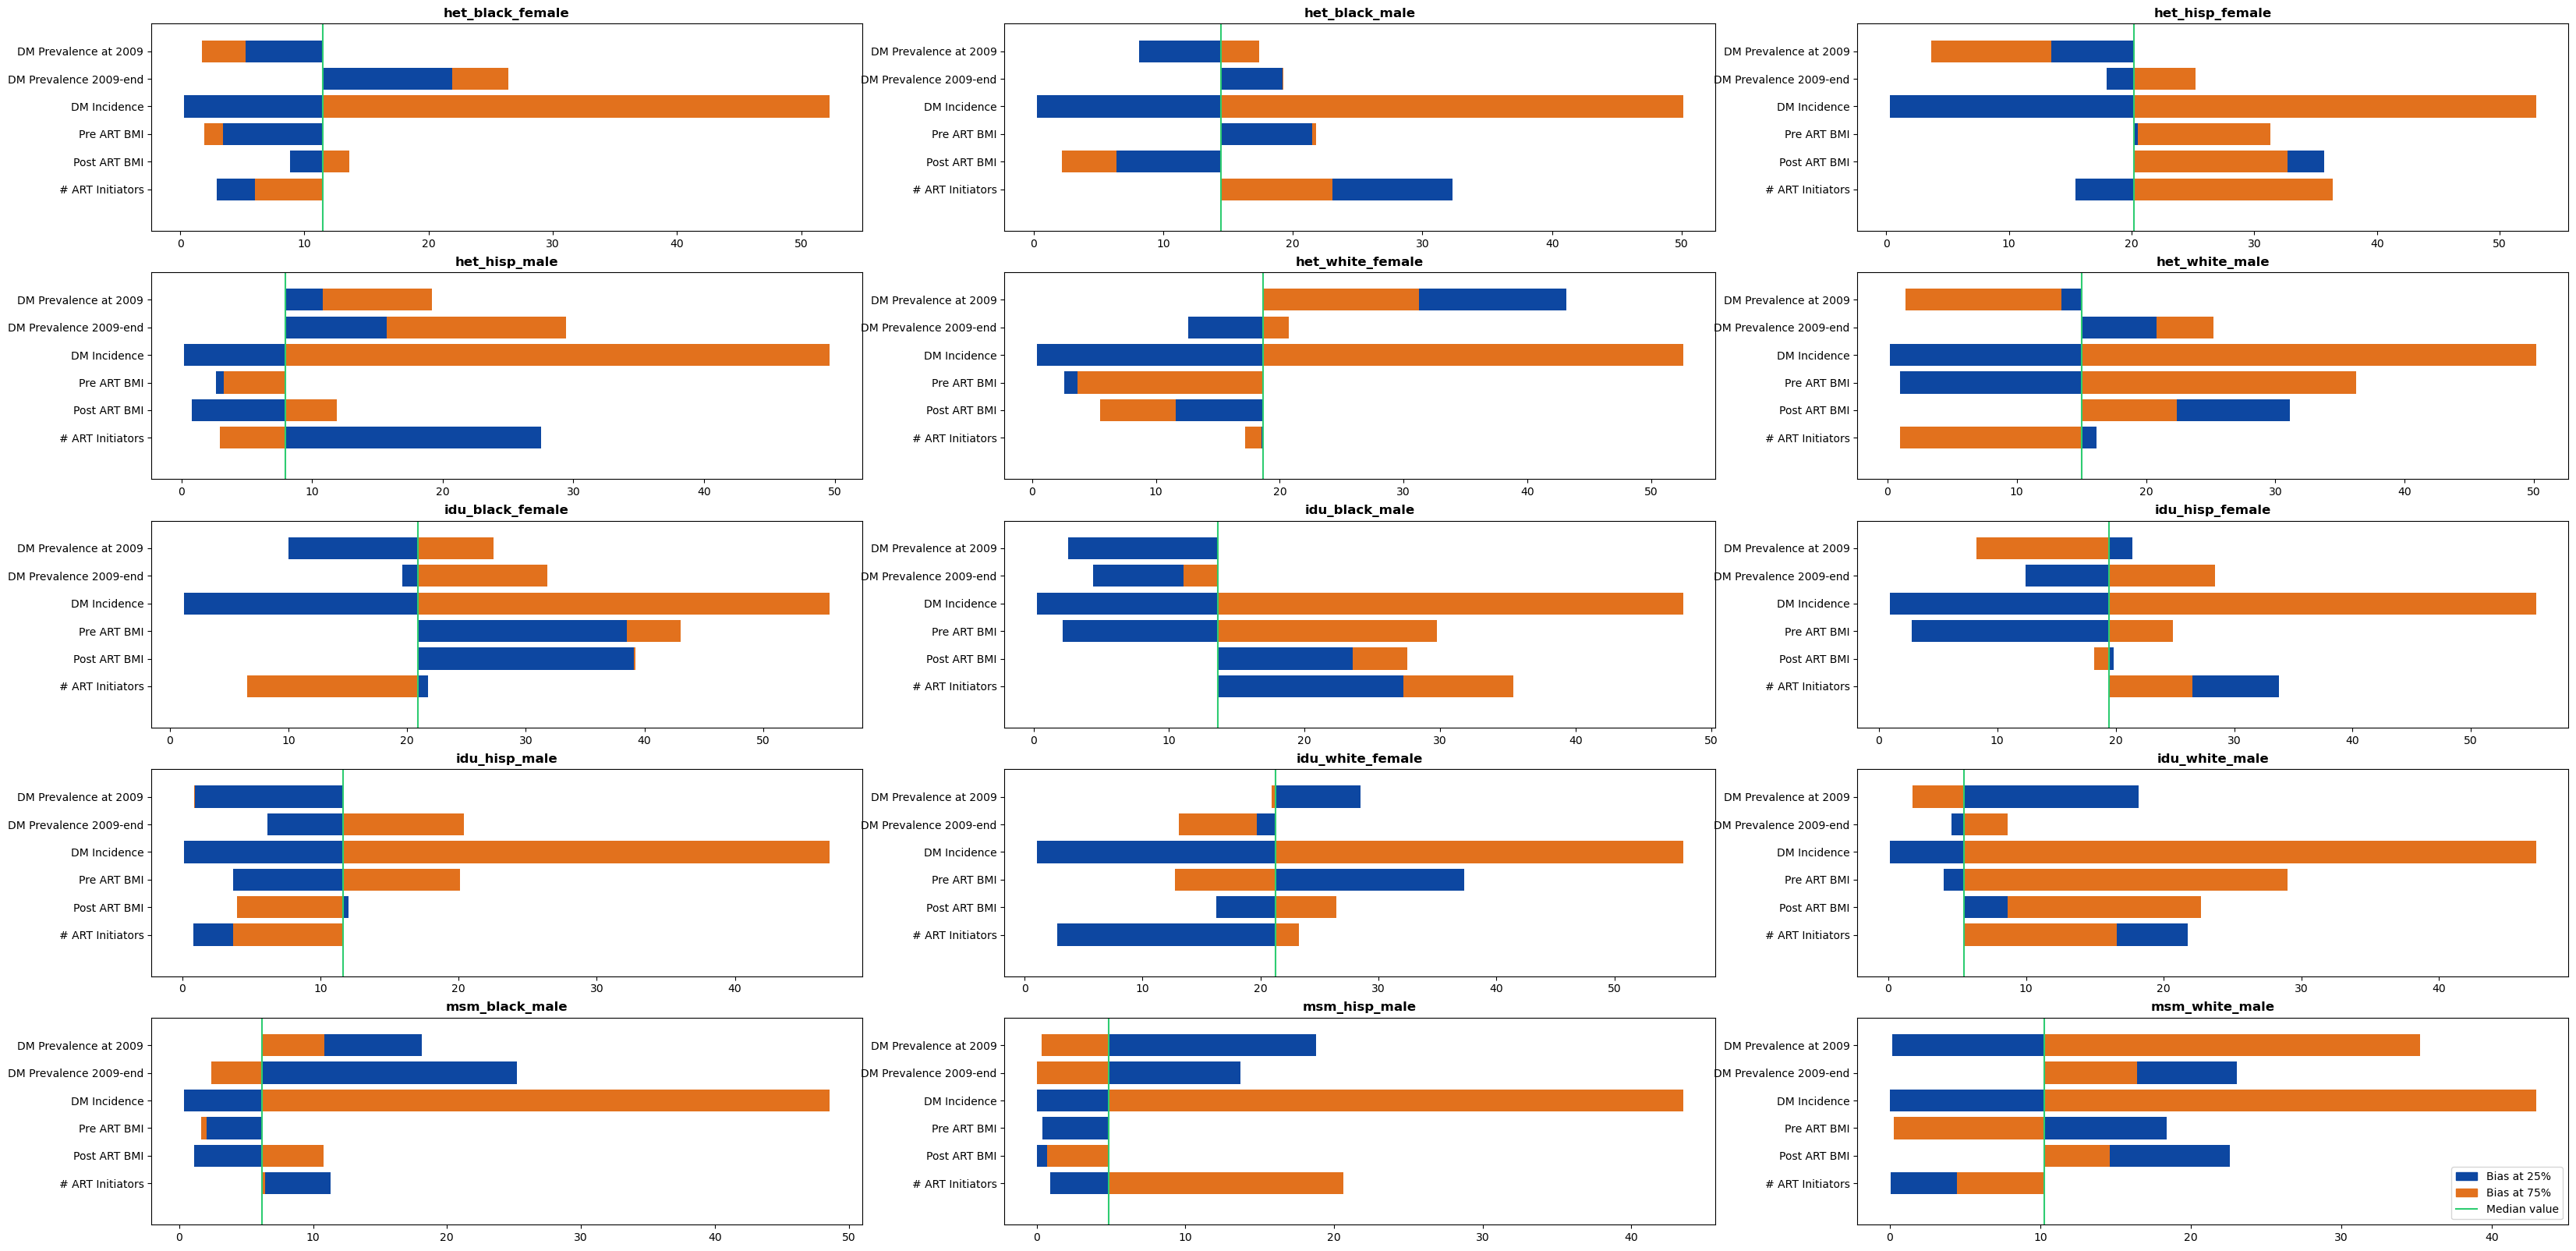

In [185]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(variable_tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = variable_tornado_vals[variable_tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = variable_risk_median[variable_risk_median['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, value_25, value_75):
        if abs(base - value) < abs(base - value2):
            ax.broken_barh([(base, value2 - base)], (y - height/2, height),facecolors=[color_95,color_95])
            ax.broken_barh([(base, value - base)], (y - height/2,height), facecolors=[color_5,color_5])
        else:
            ax.broken_barh([(base, value - base)], (y - height/2,height), facecolors=[color_5,color_5])
            ax.broken_barh([(base, value2 - base)], (y - height/2, height),facecolors=[color_95,color_95])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_title(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')


In [186]:
het_black_variable = variable_tornado_vals[variable_tornado_vals['group']== 'het_black_female']

In [187]:
het_black_variable

group                variable       0.05       0.95
0   het_black_female   DM Prevalence at 2009   5.290665   1.742893
15  het_black_female  DM Prevalence 2009-end  21.927551  26.427802
30  het_black_female            DM Incidence   0.277409  52.310472
45  het_black_female             Pre ART BMI   3.447935   1.969473
60  het_black_female            Post ART BMI   8.868165  13.610589
75  het_black_female        # ART Initiators   2.957686   6.011431

In [188]:
baseline_risk_median

group       risk
0   het_black_female  14.476859
1     het_black_male  16.621433
2    het_hisp_female  19.358199
3      het_hisp_male  13.849418
4   het_white_female  18.232118
5     het_white_male  19.954245
6   idu_black_female  21.255105
7     idu_black_male  17.876340
8    idu_hisp_female  24.824855
9      idu_hisp_male  11.929321
10  idu_white_female  27.354105
11    idu_white_male  10.360138
12    msm_black_male   7.309488
13     msm_hisp_male   2.131463
14    msm_white_male   9.066115

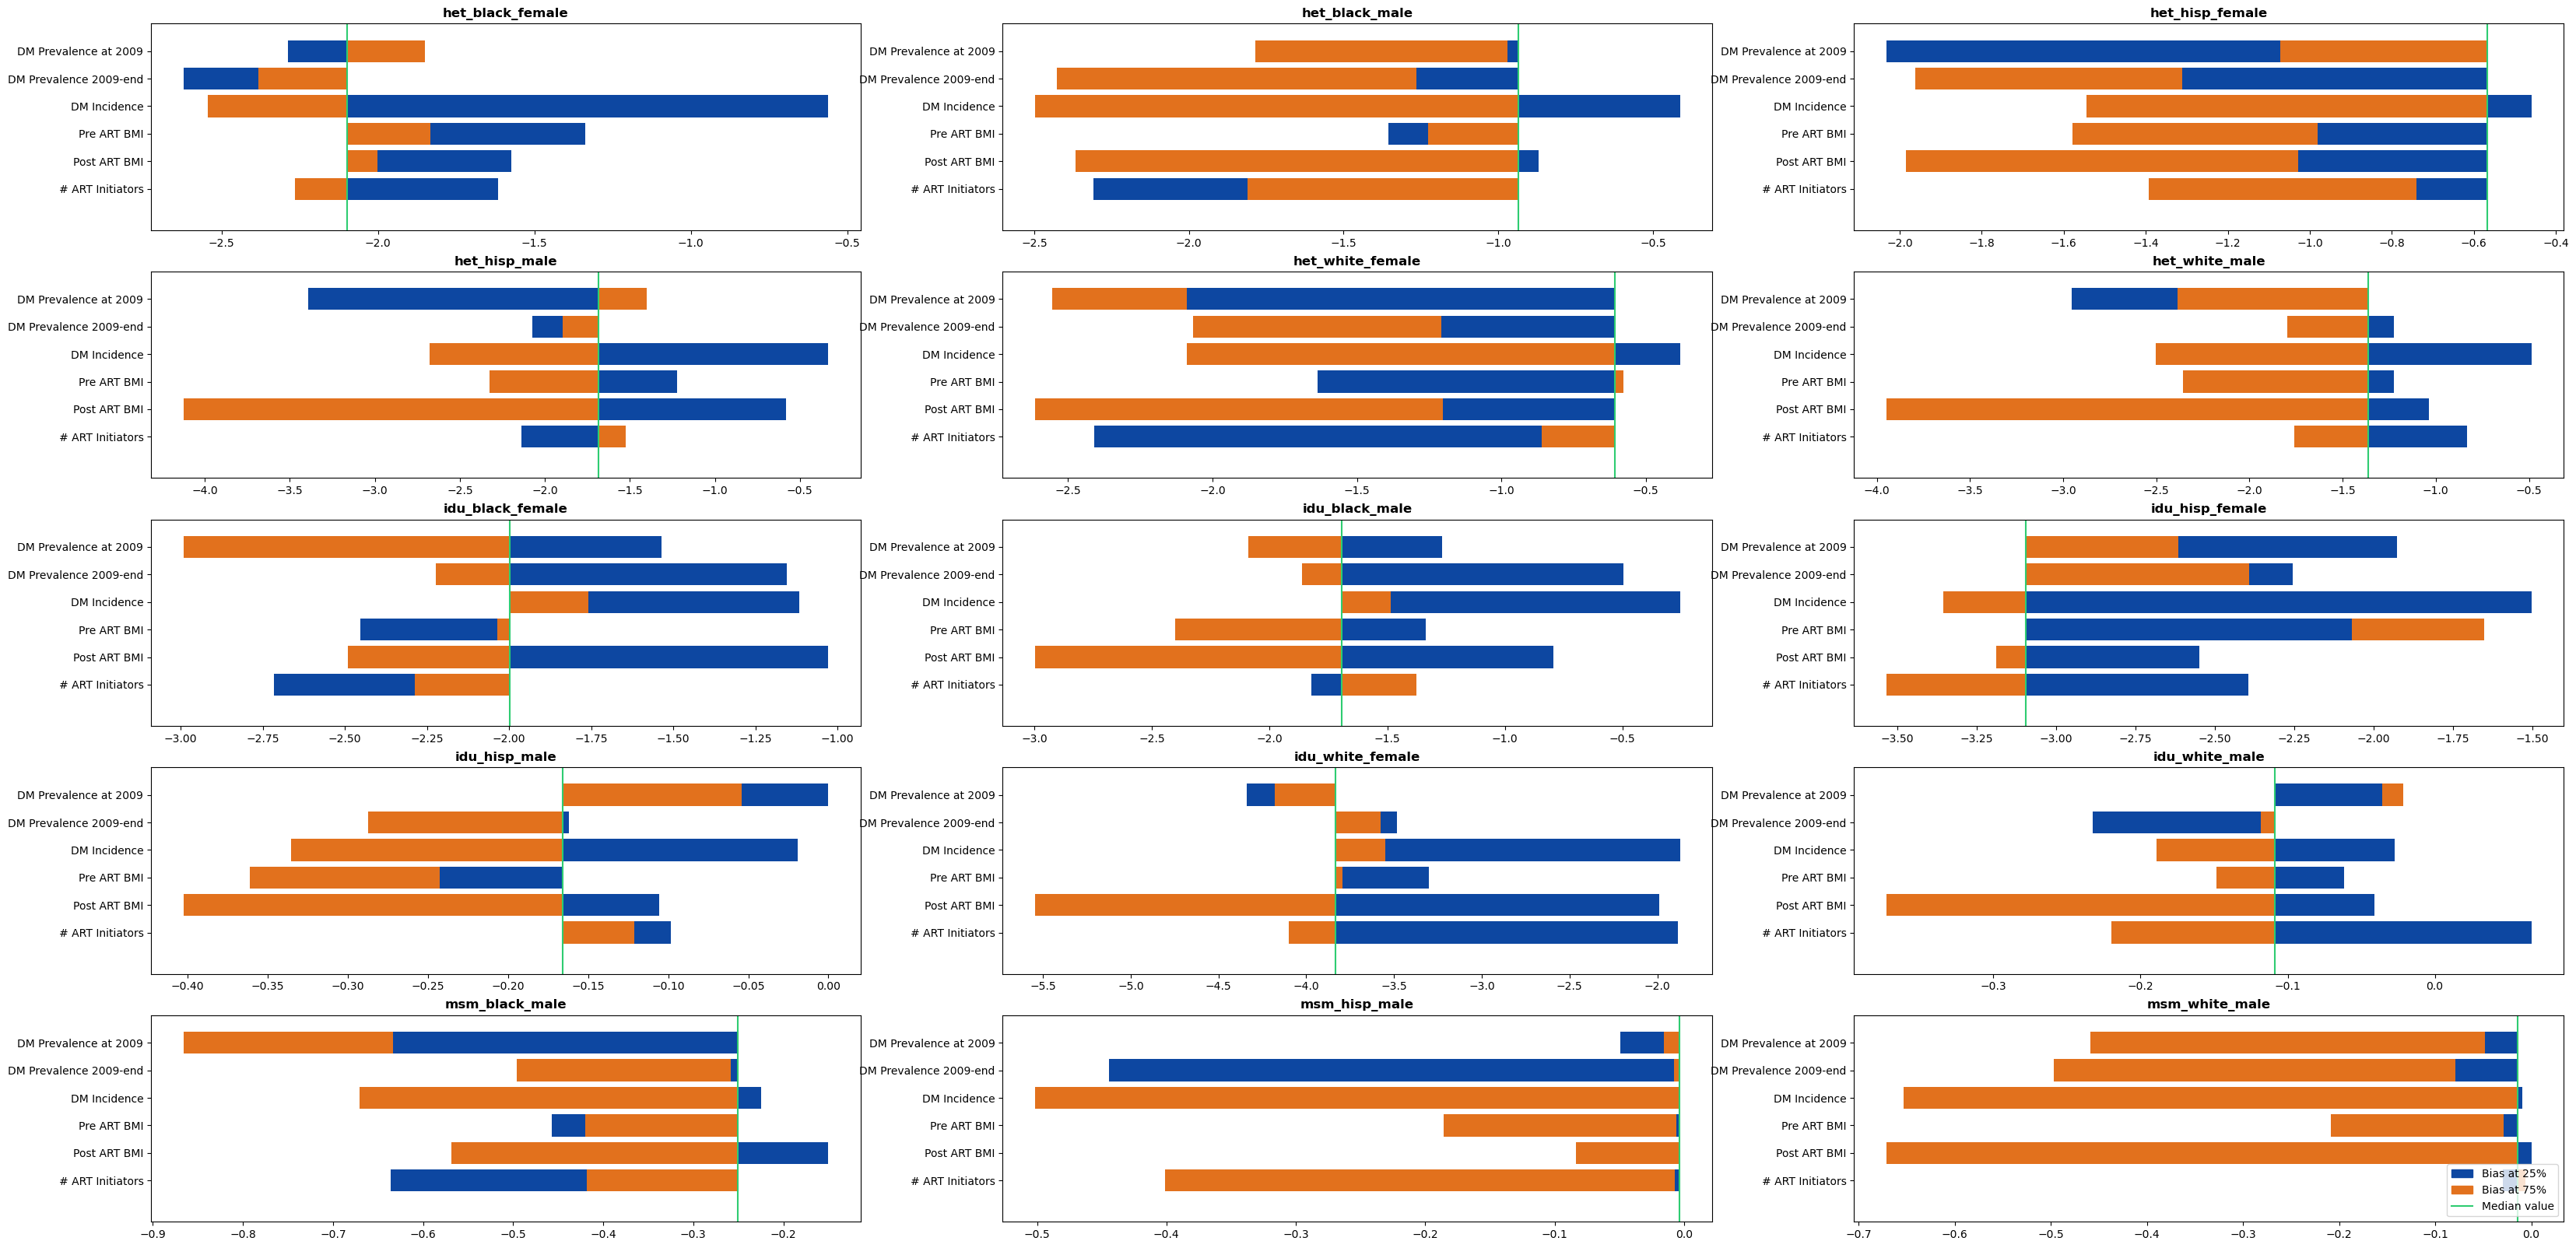

In [189]:
fig, axs = plt.subplots(5, 3, figsize=(40, 20))

plot_groups = np.sort(difference_tornado_vals.group.unique())

for i, group in enumerate(plot_groups):
    
    group_vals = difference_tornado_vals[difference_tornado_vals['group']==group].reset_index(drop=True)
    ax = axs.flatten()[i]
    
    # plot parameters
    yTick_label = group_vals['variable']
    ys = range(len(yTick_label))[::-1]
    height = 0.8
    
    color_5 = '#0d47a1'
    color_95 = '#e2711d'
    color_line = '#2ECC71'

    # Data to be visualized
    value_25 = group_vals.iloc[:,2].values
    value_75 = group_vals.iloc[:,3].values
    base = baseline_risk_difference_df[baseline_risk_difference_df['group']==group]['risk'].values[0]

    # Draw bars
    for y, value, value2 in zip(ys, value_25, value_75):
        if abs(base - value) < abs(base - value2):
            ax.broken_barh([(base, value2 - base)], (y - height/2, height),facecolors=[color_95,color_95])
            ax.broken_barh([(base, value - base)], (y - height/2,height), facecolors=[color_5,color_5])
        else:
            ax.broken_barh([(base, value - base)], (y - height/2,height), facecolors=[color_5,color_5])
            ax.broken_barh([(base, value2 - base)], (y - height/2, height),facecolors=[color_95,color_95])

    # Add vertical line for median value
    ax.axvline(base, color=color_line, linewidth=1.5, label='Median value')  

    # Modify the graph
    ax.set_ylim([-1.5, 6])
    ax.set_yticks(ys)
    ax.set_yticklabels(yTick_label)
    ax.set_title(group, fontsize=12, fontweight='bold')

    # Add legend
    handles = [Patch(color=color_5, label='Bias at 25%'), Patch(color=color_95, label='Bias at 75%'),
            Line2D([0], [0], color=color_line, linewidth=1.5, label='Median value')]
    plt.legend(handles=handles, loc='lower right')


In [190]:
difference_tornado_vals

group               variable      0.05      0.95
0   het_black_female  DM Prevalence at 2009 -2.286634 -1.848767
1     het_black_male  DM Prevalence at 2009 -0.969599 -1.786484
2    het_hisp_female  DM Prevalence at 2009 -2.032820 -1.072449
3      het_hisp_male  DM Prevalence at 2009 -3.393912 -1.401705
4   het_white_female  DM Prevalence at 2009 -2.087763 -2.556205
..               ...                    ...       ...       ...
85  idu_white_female       # ART Initiators -1.883643 -4.099936
86    idu_white_male       # ART Initiators  0.065631 -0.219557
87    msm_black_male       # ART Initiators -0.635709 -0.418050
88     msm_hisp_male       # ART Initiators -0.007322 -0.401177
89    msm_white_male       # ART Initiators -0.029723 -0.006551

[90 rows x 4 columns]